In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import shap
import joblib
import json


# Load dataset

from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = "/content/drive/My Drive/ChronicKidneyDisease_EHRs_from_AbuDhabi.csv"
df = pd.read_csv(DATA_PATH)
df.head()

Mounted at /content/drive


,Sex,AgeBaseline,HistoryDiabetes,HistoryCHD,HistoryVascular,HistorySmoking,HistoryHTN,HistoryDLD,HistoryObesity,DLDmeds,...,ACEIARB,CholesterolBaseline,CreatinineBaseline,eGFRBaseline,sBPBaseline,dBPBaseline,BMIBaseline,TimeToEventMonths,EventCKD35,TIME_YEAR
0,0,64,0,0,0,0,1,1,1,1,...,0,4.8,59.0,93.3,144,87,40,98,0,8
1,0,52,0,0,0,0,1,1,1,0,...,0,6.4,52.0,105.8,148,91,45,106,0,9
2,0,56,0,0,0,0,1,1,1,1,...,0,6.4,57.0,99.8,149,86,41,88,0,7
3,0,58,0,0,0,0,0,1,1,1,...,0,5.1,65.0,90.3,116,68,32,103,0,9
4,0,63,1,0,0,0,1,1,1,1,...,1,5.0,70.0,79.7,132,63,31,105,0,9


In [4]:
# Separate numeric and binary features

def split_features(df, target_column):
    numeric_cols = df.select_dtypes(include=['float64','int64']).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c != target_column]
    # Check for binary columns (0 or 1)
    binary_cols = [c for c in numeric_cols if df[c].dropna().isin([0,1]).all()]
    numeric_cols_clean = [c for c in numeric_cols if c not in binary_cols]
    return numeric_cols_clean, binary_cols

num_features, binary_features = split_features(df, 'EventCKD35')
cat_features = [c for c in binary_features if c != 'EventCKD35']


# EDA

print("Dataset shape:", df.shape)
print(df.describe())

Dataset shape: (491, 22)
              Sex  AgeBaseline  HistoryDiabetes  HistoryCHD  HistoryVascular  \
count  491.000000   491.000000       491.000000  491.000000       491.000000   
mean     0.509165    53.203666         0.437882    0.091650         0.059063   
std      0.500426    13.821282         0.496632    0.288825         0.235983   
min      0.000000    23.000000         0.000000    0.000000         0.000000   
25%      0.000000    44.000000         0.000000    0.000000         0.000000   
50%      1.000000    54.000000         0.000000    0.000000         0.000000   
75%      1.000000    64.000000         1.000000    0.000000         0.000000   
max      1.000000    89.000000         1.000000    1.000000         1.000000   

       HistorySmoking  HistoryHTN   HistoryDLD  HistoryObesity     DLDmeds  \
count      491.000000   491.000000  491.000000      491.000000  491.000000   
mean         0.152749     0.682281    0.645621        0.505092    0.551935   
std          0.36011

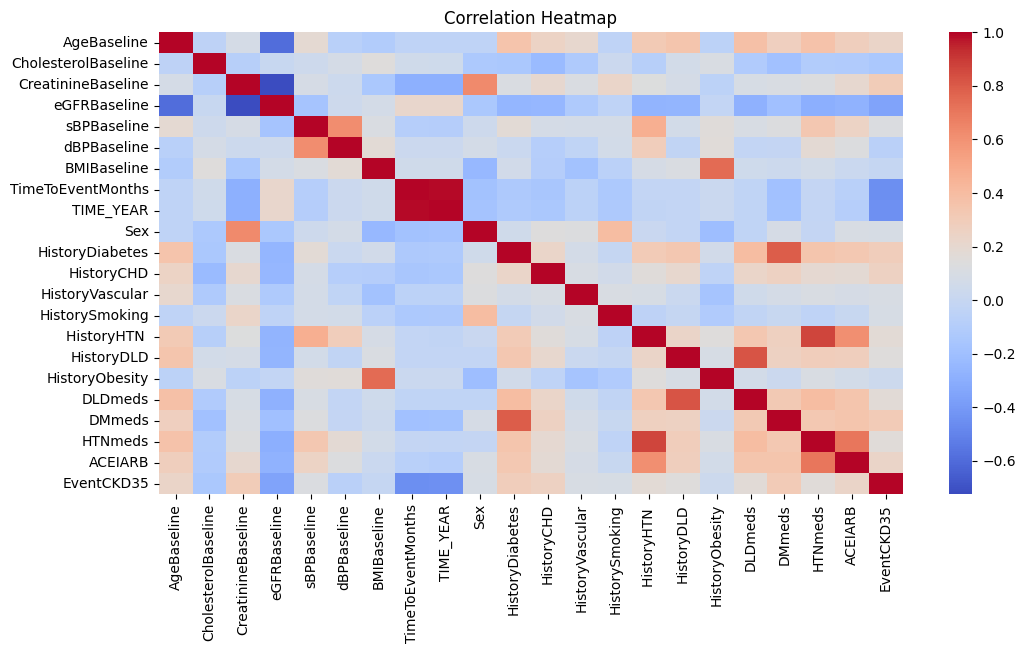

In [5]:
plt.figure(figsize=(12,6))
sns.heatmap(df[num_features + cat_features + ['EventCKD35']].corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.savefig("correlation.png", dpi=300, bbox_inches='tight')
plt.show()

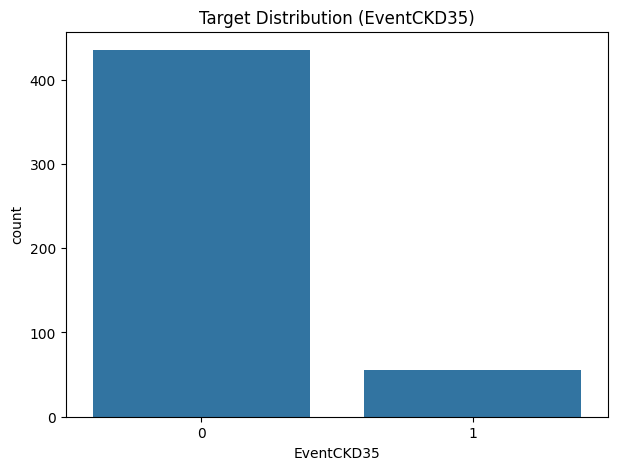

In [6]:
plt.figure(figsize=(7,5))
sns.countplot(data=df, x='EventCKD35')
plt.title("Target Distribution (EventCKD35)")
plt.show()

In [7]:
import plotly.express as px
import plotly.graph_objects as go

# Filter dataset
filtered_df = df.dropna(subset=num_features + cat_features+binary_features)

# Demographics

fig_sex = px.pie(filtered_df, names='Sex', title='Sex Distribution')
fig_sex.show()

In [8]:
fig_age = px.histogram(filtered_df, x='AgeBaseline', nbins=20, title='Age Distribution')
fig_age.show()

In [9]:
# Disease History Prevalence

diseases = ['HistoryDiabetes','HistoryCHD','HistoryVascular','HistorySmoking'
            ,'HistoryDLD','HistoryObesity']

disease_df = filtered_df[diseases].mean().reset_index()
disease_df.columns = ['Disease', 'Prevalence']

fig_disease = px.bar(disease_df, x='Disease', y='Prevalence', title='Prevalence of Risk Factors')
fig_disease.show()

In [10]:
# Lab Feature Correlation Heatmap

labs = ['CholesterolBaseline','CreatinineBaseline','eGFRBaseline','sBPBaseline','dBPBaseline','BMIBaseline']
corr_matrix = filtered_df[labs].corr()

fig_corr = go.Figure(data=go.Heatmap(
    z=corr_matrix.values,
    x=corr_matrix.columns,
    y=corr_matrix.columns,

    zmin=-1, zmax=1
))
fig_corr.update_layout(title="Correlation Heatmap of Lab Features")
fig_corr.show()

In [11]:
# CKD Event Distribution

fig_event = px.box(filtered_df, x='EventCKD35', y='TimeToEventMonths',
                   title='Time to CKD Event by Outcome', points='all')
fig_event.show()

In [12]:
# Medication

meds = ['DLDmeds', 'ACEIARB']
med_df = filtered_df[meds].mean().reset_index()
med_df.columns = ['Medication', 'Proportion']

fig_med = px.bar(med_df, x='Medication', y='Proportion', title='Proportion of Patients on Medications')
fig_med.show()

In [13]:
# Pairplot for features

selected_features = labs
fig_pair = px.scatter_matrix(filtered_df, dimensions=selected_features, color='EventCKD35',
                             title='Pairplot of Lab Features by CKD Event')
fig_pair.show()

In [14]:
# Prepare modeling

X = df.drop(columns=['EventCKD35'])
y = df['EventCKD35']

preprocess = ColumnTransformer([
    ('num',
     Pipeline([('imputer',
                SimpleImputer(strategy='median')), ('scaler', StandardScaler())]), num_features),
    ('cat', Pipeline([('imputer',
                       SimpleImputer(strategy='most_frequent'))]), cat_features)
], remainder='passthrough')

In [15]:
# Define models

models = {
    'LogisticRegression': Pipeline([('prep', preprocess), ('clf', LogisticRegression(max_iter=1000, random_state=42))]),
    'RandomForest': Pipeline([('prep', preprocess), ('clf', RandomForestClassifier(n_estimators=200, random_state=42))]),
    'XGBoost': Pipeline([('prep', preprocess), ('clf', XGBClassifier(n_estimators=200, use_label_encoder=False, eval_metric='logloss', random_state=42))]),
    'MLP': Pipeline([('prep', preprocess), ('clf', MLPClassifier(hidden_layer_sizes=(60,30), max_iter=500, random_state=42))])
}


# Split data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


# Train models and store results

results_list = []
# Store probabilities for the best model for ROC plotting later
best_model_proba = None

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    proba = model.predict_proba(X_test)[:,1]

    auc_score = roc_auc_score(y_test, proba) # Calculate AUC

    metrics = {
        'model': name,
        'accuracy': accuracy_score(y_test, pred),
        'precision': precision_score(y_test, pred, zero_division=0),
        'recall': recall_score(y_test, pred, zero_division=0),
        'f1': f1_score(y_test, pred, zero_division=0),
        'auc': auc_score
    }
    results_list.append(metrics)

results_df = pd.DataFrame(results_list)
print("\nModel Evaluation Results:")
print(results_df)

Training LogisticRegression...
Training RandomForest...
Training XGBoost...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning:

[06:26:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.




Training MLP...

Model Evaluation Results:
                model  accuracy  precision    recall        f1       auc
0  LogisticRegression  0.929293   0.833333  0.454545  0.588235  0.943182
1        RandomForest  0.939394   1.000000  0.454545  0.625000  0.946281
2             XGBoost  0.949495   0.800000  0.727273  0.761905  0.964876
3                 MLP  0.959596   0.888889  0.727273  0.800000  0.975207


In [16]:
best_model_row = results_df.sort_values('auc', ascending=False).iloc[0]
best_model_row.to_csv("ckd_model_metrics.csv", index=False)
best_model_name = best_model_row['model']
best_model = models[best_model_name]

# Retrieve probabilities for the best model now that it's selected
best_model_proba = best_model.predict_proba(X_test)[:,1]
best_model_auc = best_model_row['auc']

print(f"\nBest model selected: {best_model_name}")


Best model selected: MLP


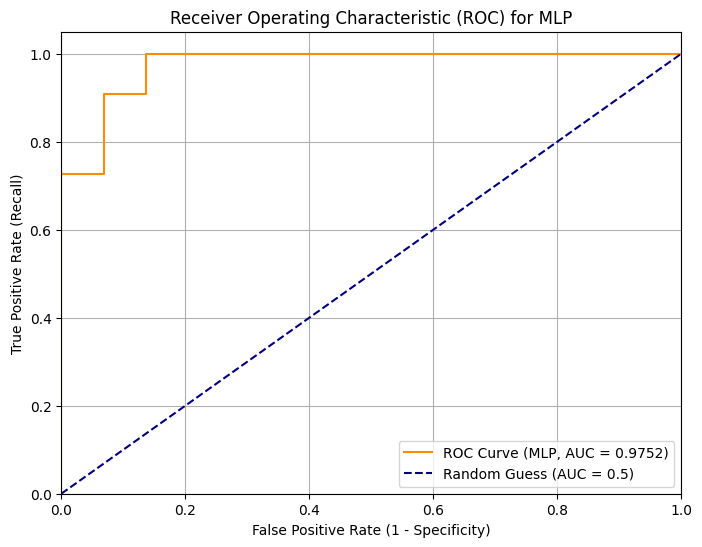

Saved ROC curve plot to roc_curve.png


In [17]:
#  ROC CURVE PLOT
# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, best_model_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve ({best_model_name}, AUC = {best_model_auc:.4f})', color='darkorange')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label='Random Guess (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Recall)')
plt.title(f'Receiver Operating Characteristic (ROC) for {best_model_name}')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("roc_curve.png", dpi=300, bbox_inches='tight')
plt.show()
print("Saved ROC curve plot to roc_curve.png")

  0%|          | 0/10 [00:00<?, ?it/s]

<Figure size 1000x600 with 0 Axes>

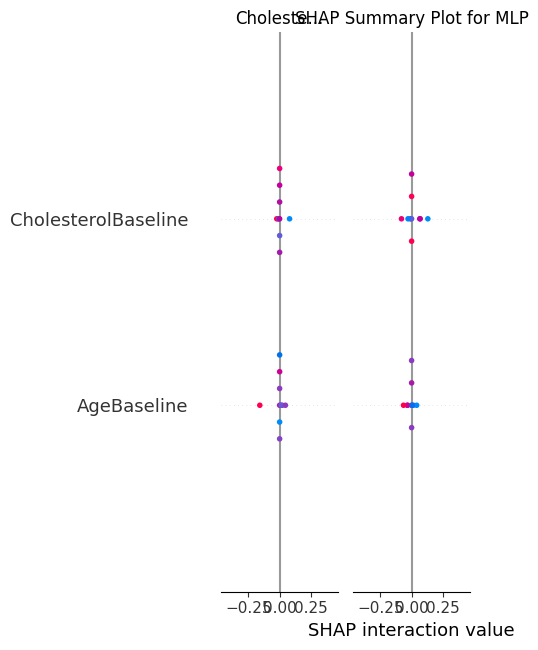

Saved MLP as best_model_pipeline.joblib


In [18]:
# Interpretability for the best model

X_train_transformed = best_model.named_steps['prep'].transform(X_train)


TRANSFORMED_FEATURE_NAMES = num_features + cat_features


# SHAP Summary Plot
if best_model_name in ['RandomForest','XGBoost']:
    explainer = shap.TreeExplainer(best_model.named_steps['clf'])

    # Use a sample of the data for SHAP value calculation and plotting

    sample_size = min(500, X_train_transformed.shape[0])
    sample_indices = np.random.choice(X_train_transformed.shape[0], sample_size, replace=False)
    X_shap_sample = X_train_transformed[sample_indices]

    shap_values = explainer.shap_values(X_shap_sample)

    # The plotting data (X_shap_sample) and feature names list (TRANSFORMED_FEATURE_NAMES)

    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values[1],
        X_shap_sample,
        feature_names=TRANSFORMED_FEATURE_NAMES,
        show=False
    )
    plt.title(f"SHAP Summary Plot for {best_model_name}")
    plt.tight_layout()
    plt.show()

else:
    # KernelExplainer for non-tree models
    X_explain = X_train_transformed[:10]
    explainer = shap.KernelExplainer(best_model.named_steps['clf'].predict_proba, X_train_transformed[:100])
    shap_values = explainer.shap_values(X_explain)

    if isinstance(shap_values, list) and len(shap_values) == 2:
        shap_values_to_plot = shap_values[1]
    else:
        shap_values_to_plot = shap_values

    plt.figure(figsize=(10, 6))
    shap.summary_plot(
        shap_values_to_plot,
        X_explain,
        feature_names=TRANSFORMED_FEATURE_NAMES,
        show=False
    )
    plt.title(f"SHAP Summary Plot for {best_model_name}")
    plt.tight_layout()
    plt.show()

# Save best model
# ----------------------------------------------
joblib.dump(best_model, "best_model_pipeline.joblib")
print(f"Saved {best_model_name} as best_model_pipeline.joblib")

In [19]:
!pip install streamlit pyngrok lime --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 99.3 MB/s eta 0:00:00


In [23]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import shap
import matplotlib.pyplot as plt
import streamlit.components.v1 as components
import tempfile
import os
from lime import lime_tabular
import matplotlib.colors as mcolors
from pyngrok import ngrok
#  ngrok token
NGROK_AUTH_TOKEN = "36jUe6NeDRFCthJbdURw8uwMUid_6xmrP84bBTRnEMuvoxCD6"

ngrok.set_auth_token(NGROK_AUTH_TOKEN)


# Configuration & Utilities

FEEDBACK_FILE_PATH = "user_feedback.csv"
DATA_PATH = "ChronicKidneyDisease_EHRs_from_AbuDhabi.csv"
MODEL_PATH = "best_model_pipeline.joblib"
BACKGROUND_IMAGE_URL = "https://ocrc.net/wp-content/uploads/2017/01/Kidney-Disease-474x400.jpg"
# File paths for model performance visualization and data
CORRELATION_IMAGE_PATH = "correlation.png"
ROC_CURVE_PATH = "roc_curve.png"  # New ROC path constant
METRICS_DATA_PATH = "ckd_model_metrics.csv"


# Utility function
def color_risk(risk):
    if risk >= 0.5:
        return "Very High"
    elif risk >= 0.3:
        return "High"
    elif risk >= 0.1:
        return " Moderate"
    else:
        return "Low"

def save_feedback(clarity, usefulness, ease_of_use, open_feedback):
    """Saves user feedback data to a CSV file."""
    data = {
        'timestamp': [pd.Timestamp.now()],
        'clarity': [clarity],
        'usefulness': [usefulness],
        'ease_of_use': [ease_of_use],
        'open_feedback': [open_feedback]
    }
    feedback_df = pd.DataFrame(data)

    # Check if file exists to determine if we need to write the header
    file_exists = os.path.isfile(FEEDBACK_FILE_PATH)

    # Append the data to the CSV
    try:
        feedback_df.to_csv(FEEDBACK_FILE_PATH, mode='a', header=not file_exists, index=False)
    except Exception as e:
        st.error(f"Failed to save feedback: {e}")

# load model and data
@st.cache_resource
def load_resources():
    try:
        data = pd.read_csv(DATA_PATH)
        pipeline_model = joblib.load(MODEL_PATH)
        # Load metrics data
        metrics_df = pd.read_csv(METRICS_DATA_PATH)
        return data, pipeline_model, metrics_df
    except FileNotFoundError as e:
        st.error(f"Error: Required file not found. Please ensure all files ('{DATA_PATH}', '{MODEL_PATH}', '{METRICS_DATA_PATH}', '{CORRELATION_IMAGE_PATH}', '{ROC_CURVE_PATH}') are available. Missing: {e.filename}")
        st.stop()
    except Exception as e:
        st.error(f"Error loading model or data: {e}")
        st.stop()

# Load all resources, unpacking the new metrics_df
df, pipeline, model_metrics_df = load_resources()

# Feature

numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
if "EventCKD35" in numeric_cols:
    numeric_cols.remove("EventCKD35")

binary_cols = [c for c in numeric_cols if df[c].dropna().isin([0,1]).all()]
cat_features = [c for c in binary_cols if c != "EventCKD35"]
num_features = [c for c in numeric_cols if c not in binary_cols]
feature_names = num_features + cat_features


# Feature Name Mapper

def prettify_name(name):
    # Remove leading/trailing spaces
    return name.strip().replace('_', ' ').title()

pretty_feature_names = [prettify_name(name) for name in feature_names]


# Streamlit Layout & CSS

st.set_page_config(page_title="CKD Risk Dashboard", layout="wide", initial_sidebar_state="expanded")

# Custom CSS for Styling, Background, and Animations
st.markdown(f"""
    <style>
    /* 1. Background Image and general theme */
    .stApp {{
        background-image: url({BACKGROUND_IMAGE_URL});
        background-size: cover;
        background-attachment: fixed;
        background-blend-mode: overlay;
        background-color: rgba(255, 255, 255, 0.75); /* Subtle white overlay */
    }}
    /* Adjust main content area background for readability */
    .main .block-container {{
        background: rgba(255, 255, 255, 0.95);
        border-radius: 10px;
        padding: 2rem;
    }}
    .sidebar .block-container {{
        background: rgba(240, 240, 245, 0.95); /* Adjusted sidebar background */
        border-radius: 10px;

    }}

    /* 2. Custom Fonts and Headings */
    .big-font {{
        font-size:30px !important;
        font-weight: bold;
        color: #1E88E5; /* A medical blue */
    }}
    h1, h2, h3, h4, h5, h6 {{
        color: #004D40; /* Dark Teal */
    }}

    /* 3. SHAP Waterfall Color  */
    .waterfall-plot .vbar path.fill {{
        fill: #ef5350 !important; /* Brighter Red for negative impact */
    }}
    .waterfall-plot .vbar path.fill:not(.negative) {{
        fill: #42a5f5 !important; /* Brighter Blue  */
    }}

    /* 4. Animation for Metric */
    @keyframes pulse {{
        0% {{ transform: scale(1); opacity: 1; }}
        50% {{ transform: scale(1.03); opacity: 0.8; }}
        100% {{ transform: scale(1); opacity: 1; }}
    }}
    .stMetric {{
        animation: pulse 2s infinite ease-in-out;
        border: 2px solid #1E88E5;
        border-radius: 10px;
        padding: 10px;
    }}

    /* Standard component adjustments */
    .stSlider [data-baseweb=slider] {{
        margin-top: -10px;
        margin-bottom: 0px;
    }}
    div.stRadio > label {{
        padding-top: 0 !important;
        padding-bottom: 0 !important;
    }}
    </style>
    """, unsafe_allow_html=True)

st.title("Chronic Kidney Disease (CKD) Risk Prediction Dashboard")
st.markdown("---")


# Sidebar: Patient Input

st.sidebar.header("Patient Case Selection")
st.sidebar.markdown("Adjust the patient's vitals and risk factors below. The prediction updates automatically.")
user_input = {}

with st.sidebar.container(border=True):
    st.sidebar.subheader("Clinical Metrics")
    for col in num_features:
        min_val, max_val = df[col].min(), df[col].max()
        user_input[col] = st.sidebar.slider(
            prettify_name(col), # Use pretty name for display
            float(min_val),
            float(max_val),
            float(df[col].median()),
            step=0.1,
            key=col
        )

with st.sidebar.container(border=True):
    st.sidebar.subheader("Comorbidity & History")

for col in cat_features:

    if col.lower() == "sex":
        # Special handling for Sex
        selected = st.sidebar.selectbox(
            "Sex",
            ["Male", "Female"],  # show labels
            index=int(df[col].median())
        )

        user_input[col] = 1 if selected == "Male" else 0

    else:
        # All other binary variables use Yes/No
        selected = st.sidebar.selectbox(
            col,
            ["Yes", "No"],
            index=int(df[col].median())
        )

        user_input[col] = 1 if selected == "Yes" else 0



X_input = pd.DataFrame([user_input])

X_transformed = pipeline.named_steps["prep"].transform(X_input)
clf = pipeline.named_steps["clf"]

# Main Content: Tabs for Organization
tab1, tab2 = st.tabs(["Patient Risk Analysis (XAI)", "Model Performance Overview"])


# Tab 1: Patient Risk & XAI
with tab1:
    col1, col2 = st.columns([1, 2])

    # Prediction Section (Left Column)
    with col1:
        st.header("Prediction Summary")

        # Prediction (Reactive)
        try:
            risk = clf.predict_proba(X_transformed)[:,1][0]
            risk_percentage = f"{risk:.2%}"
            risk_level = color_risk(risk)

            st.markdown(f'<p class="big-font">Predicted CKD Risk:</p>', unsafe_allow_html=True)
            # This metric updates every time an input is changed (the implicit 'Predict' button)
            st.metric(label="Probability of CKD Event", value=risk_percentage, delta=risk_level)

        except Exception as e:
            st.error(f"Error during prediction probability calculation: {e}")
            st.stop()

        st.subheader("Patient Vitals")
        # Display input data
        input_df = X_input.T.rename(columns={0: "Input Value"})
        input_df.index = [prettify_name(idx) for idx in input_df.index]
        st.dataframe(input_df, use_container_width=True, height=350)

    # Explanation Section (Right Column)
    with col2:
        st.header("Model Explainability (XAI)")

        # SHAP Preparation
        st.subheader("SHAP Feature Contribution")

        # Calculate transformed training data once
        X_train_data = df.drop(columns=[col for col in df.columns if col == 'EventCKD35'])
        X_train_transformed = pipeline.named_steps['prep'].transform(X_train_data)

        if clf.__class__.__name__ in ["RandomForestClassifier", "XGBClassifier"]:


            explainer = shap.TreeExplainer(clf, X_train_transformed)
            shap_values = explainer.shap_values(X_transformed)
        else:
            # KernelExplainer for non-tree models (MLP, LogReg)
            background = shap.sample(X_train_transformed, 100)
            explainer = shap.KernelExplainer(clf.predict_proba, background)
            shap_values = explainer.shap_values(X_transformed)

        # Waterfall Plot Targets Class 1
        st.markdown("##### Waterfall Plot (Impact of each feature on risk)")
        try:
            N = len(pretty_feature_names)
            shap_values_array = np.array(shap_values) # Ensure we work with a NumPy array
            expected_values_array = np.array(explainer.expected_value)

            # SHAP Value and Base Value
            if shap_values_array.ndim == 3 and shap_values_array.shape == (1, N, 2):
                shap_values_c1 = shap_values_array[0, :, 1]
                base_value_c1 = expected_values_array[1].item()
            elif isinstance(shap_values, list) and len(shap_values) > 1:
                base_value_c1 = expected_values_array[1].item()
                shap_values_c1 = shap_values[1][0]
            elif shap_values_array.ndim == 2 and shap_values_array.shape[1] == N * 2:
                base_value_c1 = expected_values_array[1].item()
                shap_values_c1 = shap_values_array[0, N:]
            elif shap_values_array.ndim == 2 and shap_values_array.shape[1] == N:
                base_value_c1 = expected_values_array[0].item()
                shap_values_c1 = shap_values_array[0]
            else:
                raise ValueError(f"Unrecognized SHAP structure. Raw shape: {shap_values_array.shape}")

            # VERIFICATION before plotting
            if shap_values_c1.size != N:
                raise ValueError(f"Final shape error: SHAP values size ({shap_values_c1.size}) != Feature count ({N}) - Raw shape: {shap_values_array.shape}")

            # Build SHAP explanation object for plotting
            shap_explanation = shap.Explanation(
                values=shap_values_c1,
                base_values=base_value_c1,
                data=X_input.iloc[0].values,
                feature_names=pretty_feature_names # Use pretty names for plot axis
            )

            # Plotting with Matplotlib
            fig, ax = plt.subplots(figsize=(10, 5))
            shap.plots.waterfall(shap_explanation, max_display=10, show=False)
            plt.tight_layout()
            st.pyplot(fig, clear_figure=True)
        except Exception as e:
            st.warning(f"Could not generate SHAP Waterfall Plot (Error: {e})")

        # Interactive Force Plot
        st.markdown("##### Interactive Force Plot")
        try:
            force_html = None

            base_value_c1_force = explainer.expected_value[1]
            shap_values_c1_force = shap_values[1] if isinstance(shap_values, list) else shap_values[..., 1]

            # If the result is a 2D array of shape (1, N), extract the first row
            if shap_values_c1_force.ndim == 2 and shap_values_c1_force.shape[0] == 1:
                shap_values_c1_force = shap_values_c1_force[0]

            force_plot_obj = shap.force_plot(
                base_value_c1_force,
                shap_values_c1_force,
                X_input.iloc[0], # Pass the single input instance Series
                feature_names=pretty_feature_names, # Use pretty names for plot axis
                link="identity"
            )

            # Save and display HTML component
            with tempfile.NamedTemporaryFile(delete=False, suffix=".html") as tmp_file:
                shap.save_html(tmp_file.name, force_plot_obj)
                tmp_file.flush()
                with open(tmp_file.name, "r") as f:
                    force_html = f.read()
            os.remove(tmp_file.name)

            if force_html:
                components.html(force_html, height=350)
        except Exception as e:
            st.warning(f"Could not generate interactive SHAP force plot: {e}")

    # LIME Explanation (Placed below columns in Tab 1)
    st.markdown("---")
    st.subheader("LIME Local Explanation")
    st.markdown("LIME identifies which features are most influential for **this specific patient's risk**.")

    try:
        lime_explainer = lime_tabular.LimeTabularExplainer(
            training_data=np.array(X_train_transformed),
            feature_names=feature_names, # LIME uses raw names internally
            class_names=["No CKD","CKD Event"],
            mode="classification",
            discretize_continuous=True
        )

        exp = lime_explainer.explain_instance(
            X_transformed[0],
            clf.predict_proba,
            num_features=10,
            labels=(1,)
        )

        # Convert LIME explanation
        st.markdown("##### Top 10 Influential Features")
        lime_df = pd.DataFrame(exp.as_list(), columns=["Feature and Condition", "Weight (Impact on CKD Risk)"])

        # Prettify feature names in the LIME DataFrame
        def prettify_lime_condition(condition):
            parts = condition.split(' ', 1)
            if len(parts) > 1:
                return prettify_name(parts[0]) + ' ' + parts[1]
            return prettify_name(parts[0])

        lime_df['Feature and Condition'] = lime_df['Feature and Condition'].apply(prettify_lime_condition)

        # Conditional styling LIME weights
        st.dataframe(lime_df.style.background_gradient(
            cmap='coolwarm',
            subset=['Weight (Impact on CKD Risk)'],
            vmin=lime_df['Weight (Impact on CKD Risk)'].min(),
            vmax=lime_df['Weight (Impact on CKD Risk)'].max()
        ).format({'Weight (Impact on CKD Risk)': "{:.4f}"}), use_container_width=True)

    except Exception as e:
        st.warning(f"Could not generate LIME Explanation: {e}")


# Tab 2: Model Performance Overview (UPDATED SECTION)
with tab2:
    st.header("Global Model Performance Metrics")
    st.markdown("This section provides a summary of the model's overall performance on the unseen test dataset.")

    st.subheader("Model Evaluation Metrics")
    try:
        # Load the single-row CSV
        metrics_display_df = model_metrics_df.copy()

        # 1. Transpose the DataFrame (Metrics become the index)
        metrics_display_df = metrics_display_df.T

        # 2. Rename the column to 'Value'. The single column will typically be indexed as 0.
        # Use metrics_display_df.columns.values[0] to dynamically get the current column index
        metrics_display_df.rename(columns={metrics_display_df.columns[0]: 'Value'}, inplace=True)

        # 3. Format the numbers for cleaner display
        # Exclude the 'model' row from formatting if it exists
        def format_metric(x):
            try:
                # Attempt to format as float if possible, otherwise return as string (e.g., model name)
                return f"{float(x):.4f}"
            except (ValueError, TypeError):
                return str(x)

        metrics_display_df["Value"] = metrics_display_df["Value"].apply(format_metric)

        # Give the index a friendly name
        metrics_display_df.index.name = "Metric"

        st.dataframe(metrics_display_df, use_container_width=True)

    except Exception as e:
        # This will now print the error, making it easier to debug future issues
        st.error(f"Failed to display model metrics from CSV: {e}")
        st.warning("Ensure 'ckd_model_metrics.csv' is a valid CSV file with one row of metrics.")

    # AUC-ROC Explanation
    with st.expander("What is AUC-ROC?"):
        st.markdown(
            """
            The **AUC-ROC (Area Under the Receiver Operating Characteristic curve)** is a critical metric for binary classification models.

            * **What it measures:** It represents the model's ability to **distinguish** between the two classes (CKD Event vs. No CKD Event) across all possible probability thresholds.
            * **Interpretation:** An AUC score of **1.0** is perfect, while **0.5** is no better than random guessing. For example, an AUC of **0.85** means the model has an 85% chance of correctly ranking a randomly chosen positive case (patient who develops CKD) higher than a randomly chosen negative case.
            * **Why it's important:** It provides a single, robust summary of performance that is **threshold-invariant** and less affected by **class imbalance** compared to simple accuracy.
            """
        )

    st.markdown("---")
    st.subheader("ROC Curve")
    st.markdown("The Receiver Operating Characteristic (ROC) curve visualizes the trade-off between the True Positive Rate (Sensitivity) and the False Positive Rate (1 - Specificity) across all thresholds. The closer the curve is to the top-left corner, the better the model's discrimination ability.")

    # Display the ROC curve image
    try:
        st.image(ROC_CURVE_PATH, caption="Receiver Operating Characteristic (ROC) Curve")
    except FileNotFoundError:
        st.error(f"Error: ROC curve image file '{ROC_CURVE_PATH}' not found.")
    except Exception as e:
        st.error(f"Failed to load ROC curve image: {e}")

    st.markdown("---")
    st.subheader("Feature Correlation Map")
    st.markdown("A heatmap showing the correlation between the various clinical features. Features with high correlation may indicate redundancy.")

    # Display the correlation image
    try:
        st.image(CORRELATION_IMAGE_PATH, caption="Correlation Heatmap of Input Features")
    except FileNotFoundError:
        st.error(f"Error: Correlation image file '{CORRELATION_IMAGE_PATH}' not found.")
    except Exception as e:
        st.error(f"Failed to load correlation image: {e}")

    st.markdown("---")
    st.subheader("Model Characteristics")
    st.info(f"The model deployed is a **{clf.__class__.__name__}** encapsulated within a scikit-learn pipeline, which includes data preprocessing steps.")
    st.markdown("This predictive framework was selected for its balance of high performance and explainability.")



# Question Feedback
st.markdown("---")
with st.expander("User Experience Feedback"):
    st.markdown("Please rate your experience with the dashboard.")

    if st.session_state.get('feedback_submitted', False):
        st.success("Thank you for your anonymous feedback!")
    else:
        with st.form("feedback_form"):
            # Define response options
            response_options = ['1', '2', '3', '4', '5']

            col1, col2, col3 = st.columns(3)

            with col1:
                q1 = st.radio("1. Clarity of Explanation?", response_options, index=2,
                              format_func=lambda x: {'1':'Very Unclear','2':'Unclear','3':'Neutral','4':'Clear','5':'Very Clear'}[x])
                q4 = st.radio("4. Navigation of Dashboard?", response_options, index=2,
                              format_func=lambda x: {'1':'Very Difficult','2':'Difficult','3':'Neutral','4':'Easy','5':'Very Easy'}[x])
                q7 = st.radio("7. Usefulness of Patient Vitals Display?", response_options, index=2,
                              format_func=lambda x: {'1':'Not Useful','2':'Slightly Useful','3':'Neutral','4':'Useful','5':'Very Useful'}[x])

            with col2:
                q2 = st.radio("2. Usefulness for Decision Support?", response_options, index=2,
                              format_func=lambda x: {'1':'Not Useful','2':'Slightly Useful','3':'Neutral','4':'Useful','5':'Very Useful'}[x])
                q5 = st.radio("5. Responsiveness of Predictions?", response_options, index=2,
                              format_func=lambda x: {'1':'Very Slow','2':'Slow','3':'Neutral','4':'Fast','5':'Very Fast'}[x])
                q8 = st.radio("8. LIME Feature Explanation Clarity?", response_options, index=2,
                              format_func=lambda x: {'1':'Very Unclear','2':'Unclear','3':'Neutral','4':'Clear','5':'Very Clear'}[x])

            with col3:
                q3 = st.radio("3. Ease of Use?", response_options, index=2,
                              format_func=lambda x: {'1':'Very Difficult','2':'Difficult','3':'Neutral','4':'Easy','5':'Very Easy'}[x])
                q6 = st.radio("6. SHAP Visualization Understandability?", response_options, index=2,
                              format_func=lambda x: {'1':'Very Unclear','2':'Unclear','3':'Neutral','4':'Clear','5':'Very Clear'}[x])
                q9 = st.radio("9. ROC & Metrics Section Helpfulness?", response_options, index=2,
                              format_func=lambda x: {'1':'Not Helpful','2':'Slightly Helpful','3':'Neutral','4':'Helpful','5':'Very Helpful'}[x])

            # 10th question
            q10 = st.radio("10. Overall Satisfaction with Dashboard?", response_options, index=2,
                           format_func=lambda x: {'1':'Very Unsatisfied','2':'Unsatisfied','3':'Neutral','4':'Satisfied','5':'Very Satisfied'}[x])

            st.markdown("---")
            open_feedback = st.text_area("Any suggestions or final comments? (Anonymous)", height=100)

            submitted = st.form_submit_button('Submit Anonymous Feedback', type="primary")

            if submitted:
                # Save all 10 questions + open feedback
                feedback_data = {
                    'timestamp': [pd.Timestamp.now()],
                    'q1_clarity': [q1],
                    'q2_usefulness': [q2],
                    'q3_ease_of_use': [q3],
                    'q4_navigation': [q4],
                    'q5_prediction_speed': [q5],
                    'q6_shap_clarity': [q6],
                    'q7_vitals_usefulness': [q7],
                    'q8_lime_clarity': [q8],
                    'q9_metrics_helpfulness': [q9],
                    'q10_overall_satisfaction': [q10],
                    'open_feedback': [open_feedback]
                }
                feedback_df = pd.DataFrame(feedback_data)

                # Append to CSV
                file_exists = os.path.isfile(FEEDBACK_FILE_PATH)
                try:
                    feedback_df.to_csv(FEEDBACK_FILE_PATH, mode='a', header=not file_exists, index=False)
                    st.session_state['feedback_submitted'] = True
                    st.success("Feedback submitted! Your input helps improve the dashboard.")
                    st.rerun()
                except Exception as e:
                    st.error(f"Failed to save feedback: {e}")


Overwriting app.py


In [24]:
import time
import subprocess
from pyngrok import ngrok

#  ngrok token
NGROK_AUTH_TOKEN = "36jUe6NeDRFCthJbdURw8uwMUid_6xmrP84bBTRnEMuvoxCD6"

ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Start ngrok
public_url = ngrok.connect(8501)

print(f"dashboard link: {public_url}**")

# Run Streamlit
subprocess.Popen(["streamlit", "run", "app.py", "--server.port", "8501"])
time.sleep(5)

dashboard link: NgrokTunnel: "https://cabalistic-anna-araceous.ngrok-free.dev" -> "http://localhost:8501"**
